<center><span style="font-family: Arial; font-size:2em;color:blue;"><b> Final project in Compressed Sensing </b></p> 
</center>

&NewLine;


<center><span style="font-family: Arial; font-size:1.5em;"><b> Re-implementation for the article "Semidefinite relaxations for certifying robustness to adversarial examples"</b></p> 
</center>


&NewLine;

<center><span style="font-family: Arial; font-size:1em;"> VU Thi Van Anh 
    </p> 
</center>

# Introduction

Recent advances deep learning and deep neural networks are widely used in solving multiple important practical problems such as image/ speech recognition, text classification and others. However, most existing machine learning classifiers, notably the neural network are highly vulnerable to adversarial problems. In recent years, many works (Szegedy et al., 2013; Goodfellow et al., 2014b; He et al., 2016) have shown that DNN models are vulnerable to adversarial examples, which can be formally defined as – “Adversarial examples are inputs to machine learning models that an attacker intentionally designed to cause the model to make mistakes.” In the image classification domain, these adversarial examples are intentionally synthesized images which look almost exactly the same as the original images, but can mislead the classifier to provide wrong prediction outputs with high confidence.

To deal with the threat of adversarial examples, several studied has been conducted such as Gradient Masking (Papernot et al., 2016b; Athalye et al., 2018), Robust
Optimization (Madry et al., 2017; Kurakin et al., 2016b) and Adversary Detection (Carlini & Wagner, 2017a; Xu et al., 2017). However, in this paper, we study the **certified defenses against attacks on neural network** proposed by Raghunathan et al, 2018. This paper proposed a Semidefinite Programming (SDP) relaxation for multi-layer networks with Rectified Linear Unit (Relu) activations and adversaries bounded by infinity norm ball. In this paper, the authors express the ReLu constraint as an equivalent quadratic constraint and the method adopted here formulates these as quadratic constraints to obtain a quadratic program that is then relaxed to an SDP. The experimental results are compelling, constructing the first certificate of robustness for verification-oblivious MNIST models with respect to moderate sized $L\infty$ perturbations.  


In this project, we focus on re-implementing SDP methods as propsed paper and testing this method with 3 models Grad-NN, LP-NN and PGD-NN. Our notebook is organized as below:
- Introducing
- Using different models to run cerfitication
  - **Grad-NN**: In this subsection, we'll consider a two-layer network based on an SDP bound on the gradient of the network.
  - **LP-NN**: In this subsection, we'll consider a two-layer network based on the Linear Programming training procedure. Linear Programming is a special case of SDP when the constraint is linear. Comparing the SDP which can handles arbitrary number of layers, LP-based neural network only accepts a layer number restricted to twp.
  - **PGD-NN**: We consider a fully-connected network with four layers containing 200;100 and 50 hidden nodes (i.e., the architecture is 784-200-100-50-10). We train this network using trainin against the strong PGD attack. 
  
  Furthermore, in each model above, we try to test with created attacks (10000 images) which are constructed by adding noises to original images, a natural idea is to de-noise adversarial examples before sending them to the target model and consider if these models can remove all adversarial perturbations?
- Conclusion.

# Simulation

**Prequirement**

In this following part of code, different convex program arises in the certification procedure are solve by toolbox **YALMIP** with **MOSEK** as backend in **MATLAB**.

Several required packages for MATLAB includes:

- YALMIP
- SEDUMI
- SDPT3
- MOSEK

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import scipy.io as sio
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm

import neural_net_params
import read_weights
import matlab_interface
import compute_bounds
import utils

D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Code\Anaconda3\envs\THANGHOANG\lib\site-packages\tensorflow\python\framework

In [2]:
# MNIST dataset parameters
num_rows = 28
num_columns = 28
num_channels = 1


# Load MNIST dataset
mnist = sio.loadmat('/Users/hoang/THANG HOANG/mnist-original.mat')
X, Y = mnist['data'].T, mnist['label'].ravel()

# Dimension
print('Dimension of X {}'.format(X.shape))
print('Dimension of Y {}'.format(Y.shape))

Dimension of X (70000, 784)
Dimension of Y (70000,)


## Simulation of model 1- Grad-NN

### Retrieve model and parameters

In [3]:
# Load model from checkpoint
reader = tf.train.load_checkpoint("models/nips_sdp.ckpt")

# Get variables' names
variable_map = reader.get_variable_to_shape_map()
checkpoint_variable_names = variable_map.keys()

print(checkpoint_variable_names)

dict_keys(['model1/dense_1/bias', 'model1/dense/bias', 'model1/dense_1/kernel', 'model1/dense/kernel'])


**Model feedforward NN with no activation function** 

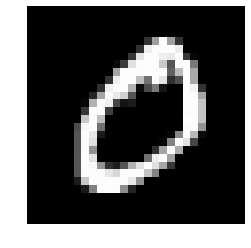

In [4]:
# This model is only feedforward layer with no activations
net_layer_types = ['ff_relu', 'ff']

# Get weights  
net_weights = [
    reader.get_tensor(tensor_str='model1/dense/kernel').T,
    reader.get_tensor(tensor_str='model1/dense_1/kernel').T
]

# Get biases
net_biases = [
    reader.get_tensor(tensor_str='model1/dense/bias'),
    reader.get_tensor(tensor_str='model1/dense_1/bias')
]

# Re-build neural net
nn_params = neural_net_params.NeuralNetParams(
  net_weights, net_biases, net_layer_types)

# Get an image belonging to class 0 from MNIST to run certification
test_input = X[0].reshape(-1,1) / 255.
true_class = Y.astype(int)[0]


# Check this image
plt.figure()
plt.imshow(test_input.reshape(28, 28))
plt.gray()
plt.axis("off")
plt.show()

In [5]:
# Some parameters for running certification on adversarial class 1 
adv_class = 1
matlab_folder = 'matlab_folder'
epsilon = 0.1
input_minval = 0
input_maxval = 1

### Run SDP Certification on adversarial class 1 

In [6]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if not os.path.exists(matlab_folder):
        os.mkdir(matlab_folder)
    matlab_object = matlab_interface.MatlabInterface(matlab_folder)
    # Save weights of NN model to matlab_object
    matlab_object.save_weights(nn_params, sess)
    opt_params = {}
    opt_params['test_input'] = test_input
    opt_params['epsilon'] = epsilon
    opt_params['true_class'] = true_class
    opt_params['adv_class'] = adv_class
    opt_params['final_linear'] = sess.run(nn_params.final_weights[adv_class, :]
             - nn_params.final_weights[true_class, :])
    opt_params['final_constant'] = sess.run(nn_params.final_bias[adv_class]
               - nn_params.final_bias[true_class])
    lower, upper = compute_bounds.compute_bounds(test_input, epsilon,
                                       input_minval, input_maxval, nn_params)
    opt_params['lower'] = [sess.run(l) for l in lower]
    opt_params['upper'] = [sess.run(u) for u in upper]
    # Save optimisation's parameters to matlab_object
    matlab_object.save_opt_params(opt_params)
    
    
    # Run certification by resolving a optimisation problem on Matlab
    os.system('matlab -sd "THANG HOANG\SDP" -batch "matlab_sdp(\'matlab_folder\')"')
    
    
    # Retrieve results and determine whether this input is certified
    opt_val = sio.loadmat(os.path.join(matlab_folder, 'SDP_optimum.mat'))
    opt_val = opt_val['val']
    if(opt_val < 0):
        print('Input example is robust to perturbation to adv class ' + str(adv_class))
    else:
        print('Input example cannot be certified as robust to perturbation to adv class ' + str(adv_class))
        exit()
print('Input example succesfully verified')

matlab_folder
(500, 784)
Input example is robust to perturbation to adv class 1
Input example succesfully verified


### Check predicted values

In [7]:
# Get 10.000 fake images
fake_images = np.repeat(test_input, 10000, axis=1) + np.random.uniform(-1, 1, (784, 10000))*0.1

# Calculating output
out_layer_1 = np.maximum(0, net_weights[0].dot(fake_images) + net_biases[0].reshape(-1, 1))
output = net_weights[1].dot(out_layer_1) + net_biases[1].reshape(-1, 1)

# Predicted values
Y_pred = np.argmax(output, axis = 0)

# Check incorrectly predicted values in class 1
np.sum(Y_pred == 1)

0

In [8]:
np.unique(Y_pred, return_counts=True)

(array([0], dtype=int64), array([10000], dtype=int64))

**Comment**

## Simulation model 2: LP-NN

### Retrieve model and parameters

In [9]:
# Load model from checkpoint
reader = tf.train.load_checkpoint("models/nips_lp.ckpt")

# Get variables' names
variable_map = reader.get_variable_to_shape_map()
checkpoint_variable_names = variable_map.keys()

print(checkpoint_variable_names)

dict_keys(['model1/dense_1/bias', 'model1/dense/bias', 'model1/dense_1/kernel', 'model1/dense/kernel'])


**Model feedforward NN with no activation function** 

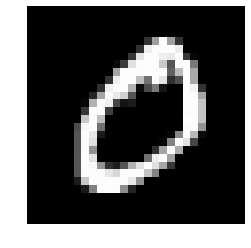

In [11]:
# This model is only feedforward layer with no activations
net_layer_types = ['ff', 'ff']

# Get weights  
net_weights = [
    reader.get_tensor(tensor_str='model1/dense/kernel').T,
    reader.get_tensor(tensor_str='model1/dense_1/kernel').T
]

# Get biases
net_biases = [
    reader.get_tensor(tensor_str='model1/dense/bias'),
    reader.get_tensor(tensor_str='model1/dense_1/bias')
]

# Re-build neural net
nn_params = neural_net_params.NeuralNetParams(
  net_weights, net_biases, net_layer_types)

# Get an image belonging to class 0 from MNIST to run certification
test_input = X[0].reshape(-1,1) / 255.
true_class = Y.astype(int)[0]

# Check this image
plt.figure()
plt.imshow(test_input.reshape(28, 28))
plt.gray()
plt.axis("off")
plt.show()

In [12]:
# Because true_class = 0, we want to run certification on adversarial class = 6
adv_class = 6
input_minval = 0
input_maxval = 1

### Run SDP Certification on adversarial class 6

In [13]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if not os.path.exists(matlab_folder):
        os.mkdir(matlab_folder)
    matlab_object = matlab_interface.MatlabInterface(matlab_folder)
    # Save weights of NN model to matlab_object
    matlab_object.save_weights(nn_params, sess)
    opt_params = {}
    opt_params['test_input'] = test_input
    opt_params['epsilon'] = epsilon
    opt_params['true_class'] = true_class
    opt_params['adv_class'] = adv_class
    opt_params['final_linear'] = sess.run(nn_params.final_weights[adv_class, :]
             - nn_params.final_weights[true_class, :])
    opt_params['final_constant'] = sess.run(nn_params.final_bias[adv_class]
               - nn_params.final_bias[true_class])
    lower, upper = compute_bounds.compute_bounds(test_input, epsilon,
                                       input_minval, input_maxval, nn_params)
    opt_params['lower'] = [sess.run(l) for l in lower]
    opt_params['upper'] = [sess.run(u) for u in upper]
    # Save optimisation's parameters to matlab_object
    matlab_object.save_opt_params(opt_params)
    
  
    # Run certification by resolving a optimisation problem on Matlab
    os.system('matlab -sd "THANG HOANG\SDP" -batch "matlab_sdp(\'matlab_folder\')"')
    
    
    # Retrieve results and determine whether this input is certified
    opt_val = sio.loadmat(os.path.join(matlab_folder, 'SDP_optimum.mat'))
    opt_val = opt_val['val']
    if(opt_val < 0):
        print('Input example is robust to perturbation to adv class ' + str(adv_class))
    else:
        print('Input example cannot be certified as robust to perturbation to adv class ' + str(adv_class))
        exit()
print('Input example succesfully verified')

matlab_folder
(500, 784)
Input example is robust to perturbation to adv class 6
Input example succesfully verified


### Check predicted values

In [14]:
# Get 10.000 fake images
fake_images = np.repeat(test_input, 10000, axis=1) + np.random.uniform(-1, 1, (784, 10000))*0.1

# Calculate predicted values
out_layer_1 = net_weights[0].dot(fake_images) + net_biases[0].reshape(-1, 1)
output = net_weights[1].dot(out_layer_1) + net_biases[1].reshape(-1, 1)

Y_pred = np.argmax(output, axis = 0)

# Incorrectly predicted values 
np.sum(Y_pred == adv_class)

0

In [15]:
# Predicted values and its occurrence
np.unique(Y_pred, return_counts=True)

(array([0], dtype=int64), array([10000], dtype=int64))

## Applying on model 3: PGD-NN

### Retrieve model and parameters

In [62]:
reader = tf.train.load_checkpoint("models/nips_pgd.ckpt")

# Get variables' names
variable_map = reader.get_variable_to_shape_map()
checkpoint_variable_names = variable_map.keys()

print(checkpoint_variable_names)

dict_keys(['model1/dense_1/bias', 'model1/dense/bias', 'model1/dense_1/kernel', 'model1/dense/kernel', 'model1/dense_2/bias', 'model1/dense_2/kernel', 'model1/dense_3/kernel', 'model1/dense_3/bias'])


In [63]:
# This model is only feedforward layer with ReLU activations
net_layer_types = ['ff_relu', 'ff_relu', 'ff_relu', 'ff']

# Get weights  
net_weights = [
    reader.get_tensor(tensor_str='model1/dense/kernel').T,
    reader.get_tensor(tensor_str='model1/dense_1/kernel').T,
    reader.get_tensor(tensor_str='model1/dense_2/kernel').T,
    reader.get_tensor(tensor_str='model1/dense_3/kernel').T,
]

# Get biases
net_biases = [
    reader.get_tensor(tensor_str='model1/dense/bias'),
    reader.get_tensor(tensor_str='model1/dense_1/bias'),
    reader.get_tensor(tensor_str='model1/dense_2/bias'),
    reader.get_tensor(tensor_str='model1/dense_3/bias'),
]

# Re-build neural net
nn_params = neural_net_params.NeuralNetParams(
  net_weights, net_biases, net_layer_types)

In [143]:
# Get randomly an image from MNIST to run certification
ind = np.random.randint(len(X))

test_input = X[ind].reshape(-1,1) / 255.
true_class = Y.astype(int)[ind]
print(true_class)

6


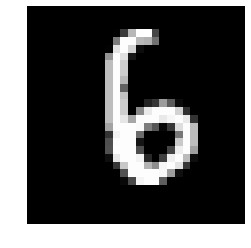

In [137]:
# Check this image
plt.figure()
plt.imshow(test_input.reshape(28, 28))
plt.gray()
plt.axis("off")
plt.show()

In [71]:
# Because true_class = 6, we want to run certification on adversarial class = 5
adv_class = 5
input_minval = 0
input_maxval = 1

### Run SDP Certification on adversarial class 5

In [72]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    if not os.path.exists(matlab_folder):
        os.mkdir(matlab_folder)
    matlab_object = matlab_interface.MatlabInterface(matlab_folder)
    # Save weights of NN model to matlab_object
    matlab_object.save_weights(nn_params, sess)
    opt_params = {}
    opt_params['test_input'] = test_input
    opt_params['epsilon'] = epsilon
    opt_params['true_class'] = true_class
    opt_params['adv_class'] = adv_class
    opt_params['final_linear'] = sess.run(nn_params.final_weights[adv_class, :]
             - nn_params.final_weights[true_class, :])
    opt_params['final_constant'] = sess.run(nn_params.final_bias[adv_class]
               - nn_params.final_bias[true_class])
    lower, upper = compute_bounds.compute_bounds(test_input, epsilon,
                                       input_minval, input_maxval, nn_params)
    opt_params['lower'] = [sess.run(l) for l in lower]
    opt_params['upper'] = [sess.run(u) for u in upper]
    # Save optimisation's parameters to matlab_object
    matlab_object.save_opt_params(opt_params)
    # Run certification by resolving a optimisation problem on Matlab
    os.system('matlab -sd "THANG HOANG\SDP" -batch "matlab_sdp(\'matlab_folder\')"')
    # Retrieve results and determine whether this input is certified
    opt_val = sio.loadmat(os.path.join(matlab_folder, 'SDP_optimum.mat'))
    opt_val = opt_val['val']
    if(opt_val < 0):
        print('Input example is robust to perturbation to adv class ' + str(adv_class))
    else:
        print('Input example cannot be certified as robust to perturbation to adv class ' + str(adv_class))
        exit()
print('Input example succesfully verified')

matlab_folder
(200, 784)
(100, 200)
(50, 100)
Input example is robust to perturbation to adv class 5
Input example succesfully verified


### Check several attack images can

In [144]:
# Get 10.000 fake images
fake_images = np.repeat(test_input, 10000, axis=1) + np.random.uniform(-1, 1, (784, 10000))*0.1

# Calculate output
out_layer_1 = np.maximum(0, net_weights[0].dot(fake_images) + net_biases[0].reshape(-1, 1))
out_layer_2 = np.maximum(0, net_weights[1].dot(out_layer_1) + net_biases[1].reshape(-1, 1))
out_layer_3 = np.maximum(0, net_weights[2].dot(out_layer_2) + net_biases[2].reshape(-1, 1))
output = net_weights[3].dot(out_layer_3) + net_biases[3].reshape(-1, 1)

In [147]:
# Predicted values
Y_pred = np.argmax(output, axis = 0)
np.sum(Y_pred == 5)

0

In [148]:
# Predicted values and occurrence
np.unique(Y_pred, return_counts=True)

(array([6], dtype=int64), array([10000], dtype=int64))

# Conclusion

With in the scope of this project, we have re-implemented the certification robustness following methods proposed by the article. More detail, all three networks proposed by the authors were employed for testing the certification with 3 image inputs, which are selected randomly from MNIST.

The results show that all these images are certified as robustness to several adversarial examples. Since all of them are certified, we still would like to try other attacks to these models by other adversarial examples (we created 10000 images by adding noise to 3 original images mentioned above) and the results show that there are no fake images can make the model turning incorrect prediction. Thus, it can be seen that this method works for all images we had chosen.


However, due to our limit of resources' capacity, we could not do more tests on more different examples with diverse classes. (In the paper, it mentioned that on a 4-core CPU, the average SDP computation took around 25 minutes and the LP around 5 minutes per example. However, it took actually more than 3 hours for each computation.)